In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import warnings
import scipy.integrate


# Declaring TFIModel 

Note this is taken from the tenpy documentation: https://tenpy.readthedocs.io/en/latest/toycode_stubs/b_model.html

In [14]:
def finite_gs_energy(L, J, g, return_psi=False):
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_x = H_x + sx_list[i]
    H = -J * H_zz - g/2. * H_x
    E, V = eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    if return_psi:
        return E[0], V[:, 0]
    return E[0]


In [15]:
def infinite_gs_energy(J, g):
    """For comparison: Calculate groundstate energy density from analytic formula.

    The analytic formula stems from mapping the model to free fermions, see P. Pfeuty, The one-
    dimensional Ising model with a transverse field, Annals of Physics 57, p. 79 (1970). Note that
    we use Pauli matrices compared this reference using spin-1/2 matrices and replace the sum_k ->
    integral dk/2pi to obtain the result in the N -> infinity limit.
    """
    def f(k, lambda_):
        return np.sqrt(1 + lambda_**2 + 2 * lambda_ * np.cos(k))

    E0_exact = -g / (J * 2. * np.pi) * quad(f, -np.pi, np.pi, args=(J / g, ))[0]
    return E0_exact

In [16]:
n = 16
g_range = np.linspace(0.1, 1.7, n)

In [17]:
J = -1

In [18]:
energies = np.zeros(n)
for i, g in enumerate(g_range):
    energy_g = infinite_gs_energy(J, -g)
    energies[i] = energy_g

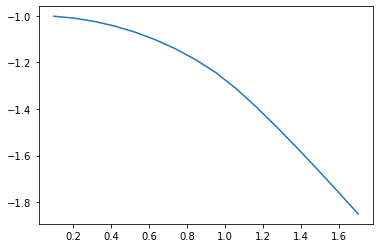

In [19]:
plt.plot(g_range, energies)

In [20]:
L = 4
fenergies = np.zeros(n)

for i, g in enumerate(g_range):
    fenergy_g = finite_gs_energy(L, J, g, return_psi=False)
    fenergies[i] = fenergy_g

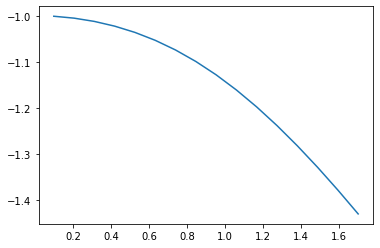

In [22]:
plt.plot(g_range, fenergies/3.)